In [1]:
%matplotlib inline
import matplotlib

In [2]:
import csv
import numpy as np
import pandas as pd
matplotlib.style.use('seaborn')
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm import tqdm

In [3]:
bcc = ["K","V","W"]
fcc = ["Al","Cu","Pd"]
hexagonal = ["Ti","Y","Re"]
cubic = fcc+bcc
all_elements = cubic+hexagonal

In [4]:
def get_mean_data(method,elements,sub_method=None):
    """Gathers the convergence data for the given method, element, 
    and sub-method, i.e. 'sc' for the Froyen method, and places it
    in a pandas dataframe where each column is a different cell 
    size and each row is a different k-point density. The dataframe also
    contains the mean error per density and numbder of instances 
    the density occures.
    
    Args:
        methad (str): "Froyen", "Mueller", or "Aflow"
        elements (list of str): A list consisting of the desired 
            elements ("V", "W", "Cu", "Al", "K", "Pd", "Ti", "Y", "Re")
        sub_method (str, optional): The sampling scheme for the 
            Froyen method ("sc", "bcc", "fcc", "hcp"). A sub_method is
            required for the Froyen method and for any other method
            this should be None.
    
    Returns:
        outdf (pandas.dataframe): A pandas dataframe of the error in
            the calculated energy at each density (row) and supercell 
            (column) in addition to a column of the average error per
            density.
    """
    for el in elements:
        if el in ["Ti","Y","Re"]:
            sizes = range(1,8)
        else:
            sizes = range(1,12)
            
        for i in sizes:
            data = []
            kpd = []
            if sub_method is None:
                f = open("../data2/{0}/{1}_conv/{2}_atom_kpd_avg_conv.csv".format(method,el,i),"r")
            else:
                f = open("../data2/{0}/{1}_conv/{2}_{3}_atom_kpd_avg_conv.csv".format(method,el,i,sub_method),"r")
            reader = csv.reader(f,delimiter='\t')
            for row in reader:
                if float(row[0]) in kpd and float(row[1]) != 0:
                    loc = kpd.index(float(row[0]))
                    data[loc][1] = (data[loc][1]+float(row[1]))/2.
                elif float(row[1]) != 0:
                    kpd.append(float(row[0]))
                    point = [float(row[0]),float(row[1])]
                    data.append(point)
                    
            data = np.array(data)
            if len(data) >= 1:
                df = pd.DataFrame(data[:,1:],index=data[:,0])#,columns=[str(i)+' atom'])    
            else:
                print("Method: {0}, element: {1}, size: {2}".format(method,el,i))
                
            if i > 1 or el != elements[0]:
                outdf = pd.concat([outdf,df], axis=1)
            else:
                outdf = df

    outdf['mean'] = outdf.mean(axis=1) 
    outdf['count'] = outdf.apply(lambda x: x.count(), axis=1)
    return outdf

In [7]:
def get_ratios(top,bottom):
    """Constructs the lists of ratios and accuracies for plotting.
    
    Args:
        top (numpy.array): The data that will be used for the top 
            half of the ratio.
        bottom (numpy.array): The data that will be used for the bottom
            half of the ratio.
            
    Returns:
        kpd, err (list, list): A list of the ratios of the k-point 
            densities, and a list of the corresponding errors.
    """
    kpd= []
    err = []
    pbar = tqdm(total=len(top))
    
    for pf in top:
        #hm = half_magnitude(pf[1])
        #hm2 = half_magnitude(pf[0])
        tr = pf[0]
        br = None
        ber = None
        dist = None
        if not pf[1] in err:
            for pm in bottom:
                #test = abs(pm[1]-pf[1])
                test = radial_dist(pf,pm)
                #test2 = abs(pm[0]-pf[1])
                if dist is None:
                    dist = test
                    br = pm[0] 
                    ber = pm[1]
                elif test < dist and abs(ber)<abs(pm[1]):
                    dist = test
                    br = pm[0]
                    ber = pm[1]
                #if test < hm:
                #    trial_set1 = [float(pf[0]),float(pm[0])]
                #    if br is not None:
                #        trial_set2 = [float(br),float(pf[0])]
                #    if br is None and ber is None:
                #        br = pm[0]
                #        ber = pm[1]
                #    elif ber < pf[1] and abs(ber-pf[1]) > test:
#                    elif abs(ber-pf[1]) > test and abs(pf[0]-pm[0])<abs(br-pf[0]):
                        #print("h")
                #        br = pm[0]
                #        ber = pm[1]
            if ber is not None and br is not None:
                err.append(pf[1])#((pf[1]+ber)/2.)
                kpd.append(float(tr)/float(br))
        pbar.update(1)
    return kpd, err

In [8]:
def binned_array(kpd_all,n):
    """Bins the ratio of k-point densities for a given error to reduce
    the noise in the plot.
    
    Args:
        kpd_all (list): The k-point density ratios.
        n (int): The bin size will be 2*n+1.
    
    Returns:
        binned_kpd_all (list): The averaged k-point density
            ratios over the bin sizes.
    """
    binned_kpd_all = []
    n_kpd = len(kpd_all)
    for i in range(n_kpd):
        temp = []
        for j in range(-n,n+1):
            if i+j >0 and i+j <n_kpd-1:
                temp.append(kpd_all[i+j])
        binned_kpd_all.append(np.mean(temp))
    return binned_kpd_all

In [9]:
def compare_methods_plot(bin_size,get_data=True):
    """This subroutine produces plot number (#) from the paper. 
    The plot compares the ratio of the different k-point densities at
    every accuracy
    
    Args:
        bin_size (int): The bin size for the averaging.
        get_data (bool, optional): True if the data needs 
            to be gathered.
    """
    
    if get_data:
        print("Collecting data.")
        # Construct dataframes of the data for each method.
        Mueller = get_mean_data("Mueller",all_elements)
        Aflow = get_mean_data("AFLOW",all_elements)
        Froyen_hcp = get_mean_data("Froyen",hexagonal,sub_method="hcp")
        Mueller_hcp = get_mean_data("Mueller",hexagonal)
        Froyen_sc = get_mean_data("Froyen",cubic,sub_method="sc")
        Froyen_bcc = get_mean_data("Froyen",cubic,sub_method="bcc")
        Froyen_fcc = get_mean_data("Froyen",cubic,sub_method="fcc")
        Mueller_cubic = get_mean_data("Mueller",cubic)
        Mueller_bcc = get_mean_data("Mueller",bcc)
        Mueller_fcc = get_mean_data("Mueller",fcc)
    
        # Convert the dataframes to numpy arrays of the density and the mean.
        Froy_sc = np.asarray(Froyen_sc.reset_index().loc[:,["index","mean"]])
        Froy_bcc = np.asarray(Froyen_bcc.reset_index().loc[:,["index","mean"]])
        Froy_fcc = np.asarray(Froyen_fcc.reset_index().loc[:,["index","mean"]])
        Froy_hcp = np.asarray(Froyen_hcp.reset_index().loc[:,["index","mean"]])
        Muel_cubic = np.asanyarray(Mueller_cubic.reset_index().loc[:,["index","mean"]])
        Muel_hcp = np.asanyarray(Mueller_hcp.reset_index().loc[:,["index","mean"]])
        Muel = np.asanyarray(Mueller.reset_index().loc[:,["index","mean"]])
        Muel_bcc = np.asanyarray(Mueller_bcc.reset_index().loc[:,["index","mean"]])
        Muel_fcc = np.asanyarray(Mueller_fcc.reset_index().loc[:,["index","mean"]])
        Afl = np.asanyarray(Aflow.reset_index().loc[:,["index","mean"]])
    
        print("Sorting errors.")
        # Sort the errors
        Muel = sort_energies(Muel)
        Afl = sort_energies(Afl)
        Froy_hcp = sort_energies(Froy_hcp)
        Froy_sc = sort_energies(Froy_sc)
        Froy_bcc = sort_energies(Froy_bcc)
        Froy_fcc = sort_energies(Froy_fcc)
        Muel_cubic = sort_energies(Muel_cubic)
        Muel_hcp = sort_energies(Muel_hcp)
        Muel_bcc = sort_energies(Muel_bcc)
        Muel_fcc = sort_energies(Muel_fcc)
    
        print("Getting ratios AFLOW.")
        # Construct the ratios for plotting
        kpd_afl, err_afl = get_ratios(Afl,Muel)
        print("Getting ratios Froyen hcp.")
        kpd_hcp, err_hcp = get_ratios(Froy_hcp,Muel_hcp)
        print("Getting ratios Froyen sc.")
        kpd_sc, err_sc = get_ratios(Froy_sc,Muel_cubic)
        print("Getting ratios Froyen bcc.")
        kpd_bcc, err_bcc = get_ratios(Froy_bcc,Muel_cubic)
        print("Getting ratios Froyen fcc.")
        kpd_fcc, err_fcc = get_ratios(Froy_fcc,Muel_cubic)
    
    print("Plotting.")
    #plt.plot(err_sc,binned_array(kpd_sc,avg_bin),label="Froyen sc")
    #plt.plot(err_bcc,binned_array(kpd_bcc,avg_bin),label="Froyen bcc")
    #plt.plot(err_fcc,binned_array(kpd_fcc,avg_bin),label="Froyen fcc")
    #plt.plot(err_hcp,binned_array(kpd_hcp,2),label="Froyen hcp")
    #plt.plot(err_afl,binned_array(kpd_afl,avg_bin),label="AFLOW")
    plt.plot(err_sc,kpd_sc,label="Froyen sc")
    plt.plot(err_bcc,kpd_bcc,label="Froyen bcc")
    plt.plot(err_fcc,kpd_fcc,label="Froyen fcc")
    plt.plot(err_hcp,kpd_hcp,label="Froyen hcp")
    plt.plot(err_afl,kpd_afl,label="AFLOW")
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel("Total Error (eV)")
    plt.ylabel("Ratio of $K$-point Densities (Method/GMP)")
    plt.legend(loc="upper right")
    plt.title("Average speedup of k-point methods vs Generalized Monkhorst-Pack")
    plt.xlim([.4E-3,1E-1])
    #plt.savefig("../plots/Y_res.pdf")
    plt.show()


Method: AFLOW, element: V, size: 1
Method: AFLOW, element: V, size: 4
Method: Froyen, element: Cu, size: 3
Method: Froyen, element: Pd, size: 3
Method: Froyen, element: V, size: 1
Method: Froyen, element: Al, size: 11
Method: Froyen, element: Cu, size: 3
Method: Froyen, element: Cu, size: 9
Method: Froyen, element: Cu, size: 10
Method: Froyen, element: Cu, size: 11
Method: Froyen, element: Pd, size: 3
Method: Froyen, element: Pd, size: 9
Method: Froyen, element: Pd, size: 10
Method: Froyen, element: V, size: 1


  0%|          | 0/1064 [00:00<?, ?it/s]

Sorting errors.
Getting ratios AFLOW.


  1%|▏         | 2/157 [00:00<00:11, 14.00it/s]

Getting ratios Froyen hcp.



  5%|▌         | 8/157 [00:00<00:10, 13.55it/s]

Exception in thread Thread-4:
Traceback (most recent call last):
  File "/usr/local/Cellar/python/2.7.9/Frameworks/Python.framework/Versions/2.7/lib/python2.7/threading.py", line 810, in __bootstrap_inner
    self.run()
  File "/Users/wileymorgan/.virtualenvs/kpoints/lib/python2.7/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/Users/wileymorgan/.virtualenvs/kpoints/bin/../lib/python2.7/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration
  6%|▋         | 10/157 [00:00<00:11, 13.06it/s]

  0%|          | 0/313 [00:00<?, ?it/s]12.99it/s]

Getting ratios Froyen sc.


  0%|          | 0/328 [00:00<?, ?it/s]

Getting ratios Froyen bcc.


  0%|          | 0/226 [00:00<?, ?it/s]

Getting ratios Froyen fcc.


100%|██████████| 226/226 [00:47<00:00,  4.81it/s]


Plotting.


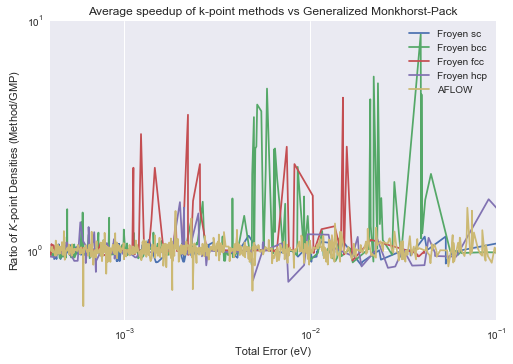

In [10]:
compare_methods_plot(5)